In [2]:
import numpy as np
import pandas as pd


# Impurity Measures
def gini_index(labels):
    """Calculates the Gini Index for a given set of labels."""
    label_counts = np.unique(labels, return_counts=True)[1]
    probabilities = label_counts / len(labels)
    return 1 - np.sum(probabilities ** 2)


def entropy(labels):
    """Calculates the entropy for a given set of labels."""
    label_counts = np.unique(labels, return_counts=True)[1]
    probabilities = label_counts / len(labels)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Adding 1e-9 to avoid log(0)


def misclassification_error(labels):
    """Calculates the misclassification error for a given set of labels."""
    label_counts = np.unique(labels, return_counts=True)[1]
    max_class_count = np.max(label_counts)
    return 1 - (max_class_count / len(labels))


def calculate_information_gain(parent, left, right, criterion="gini"):
    """Calculates information gain for a split using Gini, Entropy, or Misclassification Error."""
    n = len(parent)
    pl, pr = len(left) / n, len(right) / n
    
    if criterion == "entropy":
        parent_impurity = entropy(parent)
        left_impurity = entropy(left)
        right_impurity = entropy(right)
    elif criterion == "misclassification_error":
        parent_impurity = misclassification_error(parent)
        left_impurity = misclassification_error(left)
        right_impurity = misclassification_error(right)
    else:
        parent_impurity = gini_index(parent)
        left_impurity = gini_index(left)
        right_impurity = gini_index(right)
    
    gain = parent_impurity - (pl * left_impurity + pr * right_impurity)
    return gain


class TreeNode:
    """Represents a single node in the decision tree."""
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value  # Only used for leaf nodes


class DecisionTree:
    """Decision Tree Classifier capable of using Gini, Entropy, or Misclassification Error."""
    def __init__(self, max_depth=3, criterion="gini"):
        self.max_depth = max_depth
        self.criterion = criterion
        self.root = None
    
    def _best_split(self, dataset):
        """Finds the best split for the current dataset."""
        best_split = {'gain': -float('inf')}
        n_features = dataset.shape[1] - 1
        
        for feature_index in range(n_features):
            thresholds = np.unique(dataset[:, feature_index])
            
            for threshold in thresholds:
                left = dataset[dataset[:, feature_index] <= threshold]
                right = dataset[dataset[:, feature_index] > threshold]
                
                if len(left) > 0 and len(right) > 0:
                    parent_labels = dataset[:, -1]
                    left_labels = left[:, -1]
                    right_labels = right[:, -1]
                    gain = calculate_information_gain(parent_labels, left_labels, right_labels, self.criterion)
                    
                    if gain > best_split['gain']:
                        best_split.update({
                            'feature_index': feature_index,
                            'threshold': threshold,
                            'gain': gain,
                            'left': left,
                            'right': right
                        })
        
        return best_split
    
    def _build_tree(self, dataset, depth=0):
        """Recursively builds the decision tree."""
        labels = dataset[:, -1]
        
        # Check stopping criteria
        if depth >= self.max_depth or len(np.unique(labels)) == 1:
            leaf_value = np.bincount(labels.astype(int)).argmax()
            return TreeNode(value=leaf_value)
        
        split = self._best_split(dataset)
        
        if split['gain'] > 0:
            left_subtree = self._build_tree(split['left'], depth + 1)
            right_subtree = self._build_tree(split['right'], depth + 1)
            return TreeNode(split['feature_index'], split['threshold'], left_subtree, right_subtree, split['gain'])
        
        leaf_value = np.bincount(labels.astype(int)).argmax()
        return TreeNode(value=leaf_value)
    
    def fit(self, X, y):
        """Trains the decision tree using the provided dataset."""
        dataset = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        self.root = self._build_tree(dataset)
    
    def _predict_sample(self, x, node):
        """Predicts the class of a single data point."""
        if node.value is not None:
            return node.value
        
        if x[node.feature_index] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        """Predicts the class for a batch of samples."""
        return np.array([self._predict_sample(x, self.root) for x in X])
    
    def print_tree(self, node=None, indent="  "):
        """Prints a human-readable representation of the decision tree."""
        if node is None:
            node = self.root
        
        if node.value is not None:
            print(f"{indent}Leaf: Class = {node.value}")
        else:
            print(f"{indent}Feature[{node.feature_index}] <= {node.threshold} (Gain: {node.gain:.4f})")
            print(f"{indent}Left:")
            self.print_tree(node.left, indent + "    ")
            print(f"{indent}Right:")
            self.print_tree(node.right, indent + "    ")


In [3]:
df = pd.read_csv('Data/data_banknote_authentication.txt',names=['variance','skewness','curtosis','entropy','label'])

In [4]:
df

,variance,skewness,curtosis,entropy,label
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [5]:
import numpy as np

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Step 1**: Train the Decision Tree only on the training set
tree = DecisionTree(max_depth=15, criterion="gini")
tree.fit(X_train, y_train)

# **Step 2**: Print the tree structure
print("\nDecision Tree Structure:")
tree.print_tree()

# **Step 3**: Predict on the test set (unseen data from training)
test_predictions = tree.predict(X_test)

# **Step 4**: Print predictions and actual labels for the test set
print("\nTest Predictions:")
print(test_predictions[:20])  # Show first 20 predictions

print("\nActual Test Labels:")
print(y_test[:20])  # Show first 20 actual labels

# **Step 5**: Evaluate model performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Generate classification report
class_report = classification_report(y_test, test_predictions)

print("\nModel Accuracy on Test Data:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)




Decision Tree Structure:
  Feature[0] <= 0.31803 (Gain: 0.2624)
  Left:
      Feature[1] <= 7.6584 (Gain: 0.1463)
      Left:
          Feature[0] <= -0.46651 (Gain: 0.0170)
          Left:
              Feature[2] <= 6.2169 (Gain: 0.0033)
              Left:
                  Feature[1] <= 7.1225 (Gain: 0.0015)
                  Left:
                      Leaf: Class = 1
                  Right:
                      Feature[0] <= -4.4779 (Gain: 0.3200)
                      Left:
                          Leaf: Class = 1
                      Right:
                          Leaf: Class = 0
              Right:
                  Feature[1] <= -4.7428 (Gain: 0.1501)
                  Left:
                      Leaf: Class = 1
                  Right:
                      Feature[0] <= -2.4561 (Gain: 0.0694)
                      Left:
                          Feature[0] <= -2.7914 (Gain: 0.5000)
                          Left:
                              Leaf: Class = 0
       

In [6]:
# **Step 1**: Train the Decision Tree only on the training set
tree1 = DecisionTree(max_depth=15, criterion="entropy")
tree1.fit(X_train, y_train)

# **Step 2**: Print the tree structure
print("\nDecision Tree Structure:")
tree1.print_tree()

# **Step 3**: Predict on the test set (unseen data from training)
test_predictions = tree1.predict(X_test)

# **Step 4**: Print predictions and actual labels for the test set
print("\nTest Predictions:")
print(test_predictions[:20])  # Show first 20 predictions

print("\nActual Test Labels:")
print(y_test[:20])  # Show first 20 actual labels

# **Step 5**: Evaluate model performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Generate classification report
class_report = classification_report(y_test, test_predictions)

print("\nModel Accuracy on Test Data:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Decision Tree Structure:
  Feature[0] <= 0.31803 (Gain: 0.4297)
  Left:
      Feature[1] <= 5.8333 (Gain: 0.2869)
      Left:
          Feature[2] <= 3.0141 (Gain: 0.0678)
          Left:
              Leaf: Class = 1
          Right:
              Feature[1] <= -1.8624 (Gain: 0.3986)
              Left:
                  Feature[0] <= -0.65767 (Gain: 0.0678)
                  Left:
                      Leaf: Class = 1
                  Right:
                      Feature[2] <= 6.7156 (Gain: 0.9710)
                      Left:
                          Leaf: Class = 1
                      Right:
                          Leaf: Class = 0
              Right:
                  Feature[0] <= -2.5346 (Gain: 0.3143)
                  Left:
                      Feature[0] <= -2.7914 (Gain: 0.9183)
                      Left:
                          Leaf: Class = 0
                      Right:
                          Leaf: Class = 1
                  Right:
                      Leaf

In [7]:
import pandas as pd

# Load the CSV file properly
df = pd.read_csv('Data/Predict_student_dropout_and_academic_success.csv', sep=';')


In [8]:
df.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd

In [9]:
df.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [11]:
df.Target.unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

In [12]:
df.Target.value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

In [13]:
d = {'Graduate' : round(df.Target.value_counts()[0]/df.shape[0]*100,2),
     'Dropout' : round(df.Target.value_counts()[1]/df.shape[0]*100,2),
     'Enrolled' : round(df.Target.value_counts()[2]/df.shape[0]*100,2)}
print(d)

{'Graduate': 49.93, 'Dropout': 32.12, 'Enrolled': 17.95}


C:\Users\hardi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


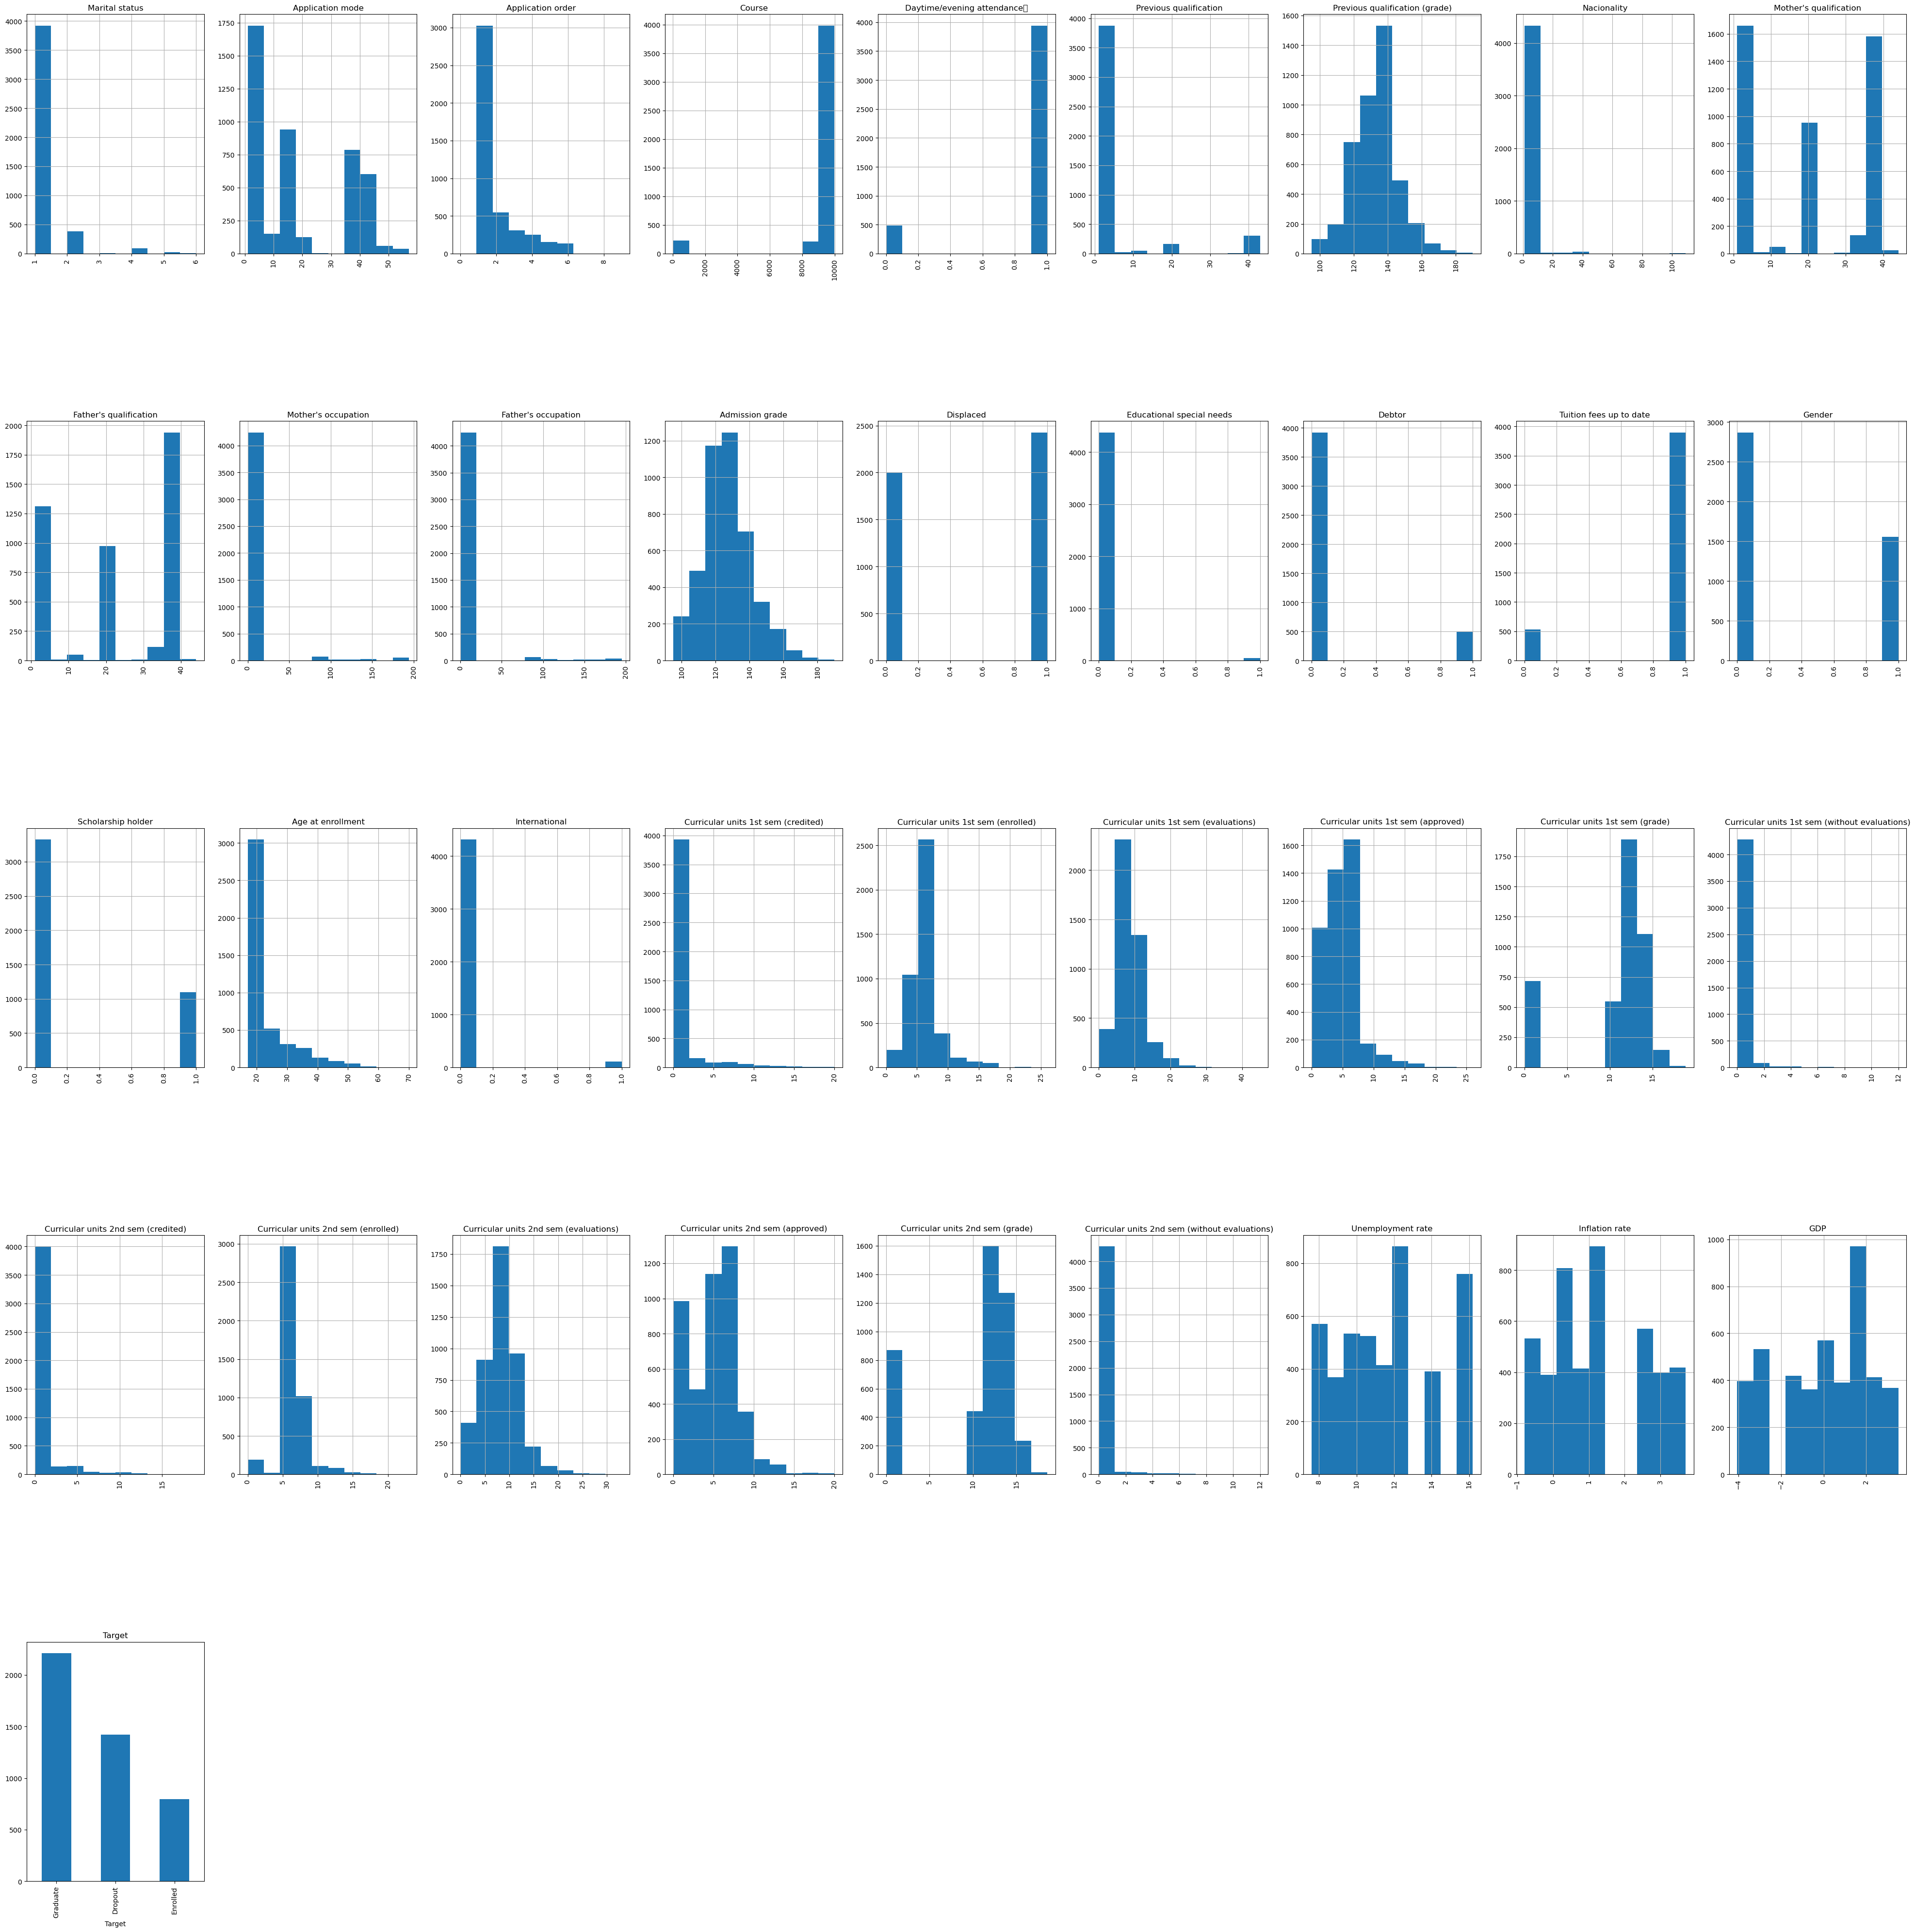

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Number of columns in the grid
cols = 9
# Calculate total rows required (use np.ceil to round up)
rows = int(np.ceil(df.shape[1] / cols))  # Ceil to ensure no leftover columns are missed

fig = plt.figure(figsize=(50, 50))  # Figure size
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)  # Create a subplot
    ax.set_title(column)
    if df.dtypes[column] == np.object_:
        df[column].value_counts().plot(kind="bar", ax=ax)
    else:
        df[column].hist(ax=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()


In [15]:
from sklearn.preprocessing import LabelEncoder

# Assume 'Target' is your target column
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])  # Encode target to 0, 1, 2

In [16]:
df.Target.dtype

dtype('int32')

In [17]:
import numpy as np

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Step 1**: Train the Decision Tree only on the training set
tree = DecisionTree(max_depth=3, criterion="entropy")
tree.fit(X_train, y_train)

# **Step 2**: Print the tree structure
print("\nDecision Tree Structure:")
tree.print_tree()

# **Step 3**: Predict on the test set (unseen data from training)
test_predictions = tree.predict(X_test)

# **Step 4**: Print predictions and actual labels for the test set
print("\nTest Predictions:")
print(test_predictions[:20])  # Show first 20 predictions

print("\nActual Test Labels:")
print(y_test[:20])  # Show first 20 actual labels

# **Step 5**: Evaluate model performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Generate classification report
class_report = classification_report(y_test, test_predictions)

print("\nModel Accuracy on Test Data:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)




Decision Tree Structure:
  Feature[30] <= 3.0 (Gain: 0.3450)
  Left:
      Feature[22] <= 0.0 (Gain: 0.1051)
      Left:
          Feature[16] <= 0.0 (Gain: 0.0856)
          Left:
              Leaf: Class = 0
          Right:
              Leaf: Class = 2
      Right:
          Feature[30] <= 0.0 (Gain: 0.1703)
          Left:
              Leaf: Class = 0
          Right:
              Leaf: Class = 0
  Right:
      Feature[30] <= 5.0 (Gain: 0.0776)
      Left:
          Feature[16] <= 0.0 (Gain: 0.1021)
          Left:
              Leaf: Class = 0
          Right:
              Leaf: Class = 2
      Right:
          Feature[23] <= 8.0 (Gain: 0.0503)
          Left:
              Leaf: Class = 2
          Right:
              Leaf: Class = 2

Test Predictions:
[0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0 2 2 0 2]

Actual Test Labels:
[0 2 2 2 0 2 1 0 2 2 2 2 0 2 0 1 1 2 1 2]

Model Accuracy on Test Data: 0.7209039548022599

Confusion Matrix:
[[233   0  83]
 [ 57   0  94]
 [ 13   0 405]]

Clas

C:\Users\hardi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hardi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hardi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

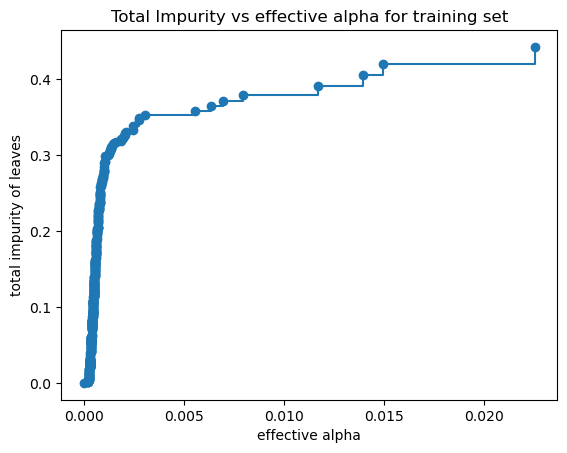

In [18]:
from sklearn.tree import DecisionTreeClassifier 
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Number of nodes in the last tree is: 1 with ccp_alpha: 0.17082532673714423


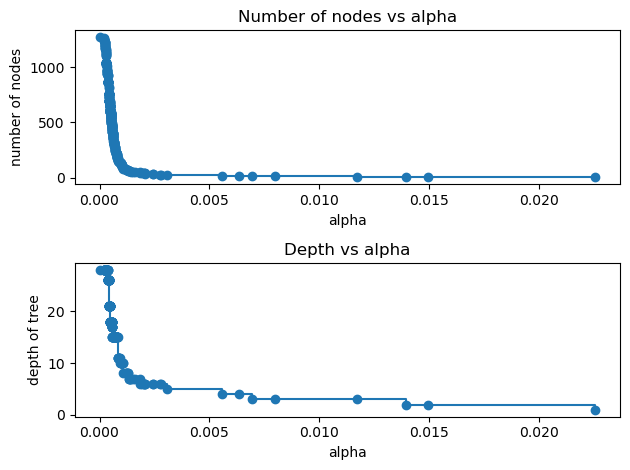

In [19]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

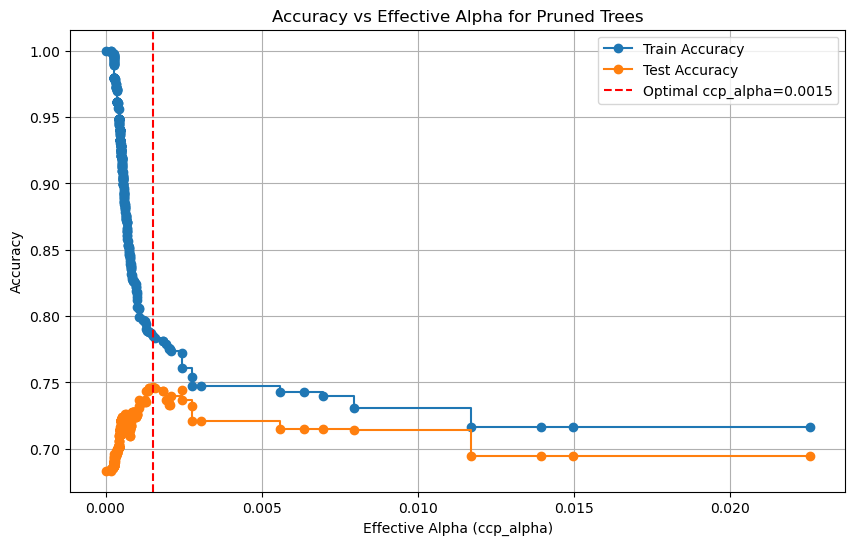

0.0015096539983458085

In [20]:
# Evaluate accuracy on train and test sets
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# Find the optimal ccp_alpha (where test accuracy is maximized)
optimal_index = test_scores.index(max(test_scores))
optimal_ccp_alpha = ccp_alphas[optimal_index]

# Plot accuracy vs. ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker="o", label="Train Accuracy", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker="o", label="Test Accuracy", drawstyle="steps-post")
plt.axvline(x=optimal_ccp_alpha, color='r', linestyle='--', label=f'Optimal ccp_alpha={optimal_ccp_alpha:.4f}')
plt.xlabel("Effective Alpha (ccp_alpha)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Effective Alpha for Pruned Trees")
plt.legend()
plt.grid()
plt.show()

optimal_ccp_alpha


In [21]:
# Train the final pruned tree with the optimal ccp_alpha
final_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=optimal_ccp_alpha)
final_clf.fit(X_train, y_train)

# Evaluate the final pruned tree
train_accuracy = final_clf.score(X_train, y_train)
test_accuracy = final_clf.score(X_test, y_test)

train_accuracy, test_accuracy

(0.7849675049448996, 0.7468926553672316)

In [22]:
# Train the final pruned tree with the optimal ccp_alpha
final_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0)
final_clf.fit(X_train, y_train)

# Evaluate the final pruned tree
train_accuracy = final_clf.score(X_train, y_train)
test_accuracy = final_clf.score(X_test, y_test)

train_accuracy, test_accuracy

(1.0, 0.6836158192090396)

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],  # None means no maximum depth
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],  # None = all features
    'ccp_alpha': np.linspace(0, 0.02, 100),  # 10 values for ccp_alpha
}

# Create the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',  # Optimize for accuracy
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=1  # Show progress
)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train the final model with the best parameters
final_dt = grid_search.best_estimator_

# Evaluate the final model on the test set
y_pred = final_dt.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Evaluate the final pruned tree
train_accuracy = final_dt.score(X_train, y_train)
test_accuracy = final_dt.score(X_test, y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)



Fitting 5 folds for each of 10800 candidates, totalling 54000 fits
Best Parameters: {'ccp_alpha': 0.0014141414141414141, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Cross-Validation Accuracy: 0.7612283141147045

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.67      0.75       316
           1       0.50      0.34      0.40       151
           2       0.74      0.95      0.83       418

    accuracy                           0.75       885
   macro avg       0.70      0.65      0.66       885
weighted avg       0.74      0.75      0.73       885

Train Accuracy: 0.7880757276066686
Test Accuracy: 0.7457627118644068
